This is my pytorch hello world. 

In addition to get familiar with the basic usage, I also want to demonstrate the universal approximation property of neural nets, which I believe is one of the core reason why deep learing is working so well.

Consider the characteristic function for two interected circles on the 2-d plane (then the problem naturally becomes a classification problem), we will see that a nn with 2 hidden layer can aprroximate it pretty well. 

We remark here that actually only one layer is good enough since we know that even the one layer nn also has the universal approximation property.

In [36]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from random import shuffle

The objective function below equals one within two intersected circles, first one centered at $(0,0)$ with a radius of $0.6$ and the second one entered at $(0.5,0.5)$ with a radius of $0.5$.

Notice that the region is non-convex.

In [37]:
def target(x,y):
    if (x-0.0)*(x-0.0) + (y-0.0)*(y-0.0) < 0.36 or (x-0.5)*(x-0.5) + (y-0.5)*(y-0.5) < 0.25:
        return 1.0
    else:
        return 0.0

Define our neural net with 2 hidden layer. It takes a 2-d input and map to the first layer with 40 hidden units, then two the second hidden layer with 40 nodes and finally map to a scalar output.

Also define the optimization method (Adam) and the loss function (cross entropy).

In [38]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()     
        self.fc1 = nn.Linear(2, 40) 
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.out_act(x)
        return x

net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
lose_func = nn.BCELoss()

We sample data uniformly from a square $[-1.5,1.5]\times [-1.5,1.5]$, label them and do a shuffle.

One interesting here is that if you don't shuffle the input, the performance is prerry bad.

In [43]:
x = []
y = []
for i in numpy.linspace(-1.5,1.5,num = 200):
    for j in numpy.linspace(-1.5,1.5,num = 200):
        x = x + [[i,j]]

# try to comment out this and see what happens
shuffle(x)

for i in x:
    y = y + [[target(i[0],i[1])]]

A function used to visualize the data, x is a list of 2-d points and y is the list of label associated with x.

In [44]:
def draw(x,y, threshold = 1.0):
    blue_x = []
    blue_y = []
    red_x = []
    red_y = []
    for i in range(len(x)):
        if y[i][0] >= threshold:
            blue_x = blue_x + [x[i][0]]
            blue_y = blue_y + [x[i][1]]
        else:
            red_x = red_x + [x[i][0]]
            red_y = red_y + [x[i][1]]
      
    [fig, ax] = plt.subplots()
    plt.scatter(blue_x, blue_y, color='b')
    plt.scatter(red_x, red_y, color='r')

This is the original input data, equals 1 inside the two circles and 0 otherwise.

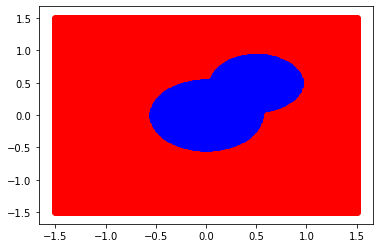

In [45]:
draw(x,y)

Now we start to train the model

In [46]:
x = torch.tensor(x)
y = torch.tensor(y)

In [47]:
def train_epoch(model, opt, criterion, batch_size=50):
    losses = []
    for beg_i in range(0, x.size(0), batch_size):
        x_batch = x[beg_i:beg_i + batch_size, :]
        y_batch = y[beg_i:beg_i + batch_size, :]
        
        opt.zero_grad()
        y_hat = net(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [48]:
e_losses = []
num_epochs = 100
for e in range(num_epochs):
    train_epoch(net, opt, lose_func)

This is the final result. I was pretty astonished when I saw the result for the first time. Before that, I didn't really believe in deep learning since it was really a black box to me. The result here changed my mind.

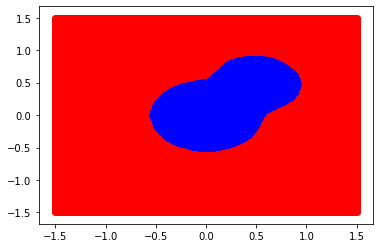

In [49]:
draw(x.tolist(), net(x).tolist(), threshold = 0.5)

The decision boundary given by this nn should be linear, basically some polygon, which can be easily seen if we decrease the number of hidden units. So what we are doing here is basically try to approximate any region (don't need to be convex) using polygon and we know it is feasible from real analysis.

Then some question to ask here are: 
    1. Given any polygon $P$, can we find a nn whose decision boundary is exactly $P$, if so, how to construct it.
    2. Given a network structure, give an upper bound of the number of edges of its decision boundary.